In [50]:
# Markup: Data Loading and Processing Functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler # Added RobustScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline
import time
from sklearn.model_selection import learning_curve # Added learning_curve import

# Function to load and process a single year of data
def load_and_process_data(filepath):
    """
    Load and process a single year of play-by-play data.
    Returns a DataFrame with game-level aggregated statistics.
    """
    print(f"Loading data from {filepath}...")
    df = pd.read_csv(filepath)
    print(f" Data shape: {df.shape}")

    # Group by game to create game-level features
    game_stats = {}

    # Iterate through each unique game
    for game_id in df['GameId'].unique():
        game_df = df[df['GameId'] == game_id]

        # Get unique teams in this game
        teams = set(game_df['OffenseTeam'].dropna().unique()) | set(game_df['DefenseTeam'].dropna().unique())
        teams = [team for team in teams if isinstance(team, str) and team.strip()]

        # Skip if we don't have exactly 2 teams
        if len(teams) != 2:
            continue

        home_team, away_team = teams[0], teams[1] # Approximation

        # Initialize team stats dictionaries (add new stats)
        home_stats = {
            'total_yards': 0, 'pass_yards': 0, 'rush_yards': 0,
            'pass_attempts': 0, 'rush_attempts': 0, 'turnovers': 0,
            'sacks_taken': 0, 'penalties': 0, 'penalty_yards': 0,
            'touchdowns': 0, 'field_goals': 0,
            'third_down_attempts': 0, 'third_down_conversions': 0, # New
            'fg_attempts': 0, 'punt_yards': 0 # New
        }

        away_stats = home_stats.copy()

        # Calculate stats for each team
        for _, play in game_df.iterrows():
            if not isinstance(play['OffenseTeam'], str) or not play['OffenseTeam'].strip():
                continue

            # Determine which team's stats to update
            if play['OffenseTeam'] == home_team:
                current_team_stats = home_stats
                opp_team_stats = away_stats # For sacks given by defense
                current_team_field = play['OffenseTeam']
            else:
                current_team_stats = away_stats
                opp_team_stats = home_stats # For sacks given by defense
                current_team_field = play['OffenseTeam']

            # Track yards
            if pd.notna(play['Yards']):
                current_team_stats['total_yards'] += play['Yards']
                if play['IsRush'] == 1:
                    current_team_stats['rush_yards'] += play['Yards']
                    current_team_stats['rush_attempts'] += 1
                elif play['IsPass'] == 1:
                    # Pass yards include sack yards in official stats, but 'Yards' here might be net gain
                    # We'll use the 'Yards' column directly for pass plays
                    current_team_stats['pass_yards'] += play['Yards']
                    current_team_stats['pass_attempts'] += 1

            # Count other important stats
            if play['IsSack'] == 1:
                # Sack is recorded against the offense
                current_team_stats['sacks_taken'] += 1
                # Pass attempt should still be counted if it was a sack
                # Check if IsPass is 1 on sack plays - if not, increment pass_attempts here
                if play['IsPass'] != 1:
                     current_team_stats['pass_attempts'] += 1

            if play['IsInterception'] == 1 or play['IsFumble'] == 1:
                current_team_stats['turnovers'] += 1
            if play['IsPenalty'] == 1 and pd.notna(play['PenaltyTeam']) and play['PenaltyTeam'] == current_team_field:
                current_team_stats['penalties'] += 1
                if pd.notna(play['PenaltyYards']): # Only count yards if penalty accepted? Assume yes for now
                     current_team_stats['penalty_yards'] += play['PenaltyYards']

            # Scoring Plays
            if play['IsTouchdown'] == 1 and current_team_field == play['OffenseTeam']: # Ensure offense scored
                current_team_stats['touchdowns'] += 1
            if play['PlayType'] == 'FIELD GOAL':
                current_team_stats['fg_attempts'] += 1 # Count attempt
                if 'IS GOOD' in str(play['Description']).upper():
                    current_team_stats['field_goals'] += 1 # Count make

            # Third Downs
            if play['Down'] == 3:
                current_team_stats['third_down_attempts'] += 1
                if play['SeriesFirstDown'] == 1:
                    current_team_stats['third_down_conversions'] += 1

            # Punt Yards (assuming 'Yards' on PUNT is net yardage, might need validation)
            if play['PlayType'] == 'PUNT':
                 if pd.notna(play['Yards']):
                    current_team_stats['punt_yards'] += play['Yards']


        # Estimate final score (simplified)
        home_score = home_stats['touchdowns'] * 7 + home_stats['field_goals'] * 3 # Simplified, ignores PATs/2pt
        away_score = away_stats['touchdowns'] * 7 + away_stats['field_goals'] * 3 # Simplified

        # Determine winner (1 if home team wins, 0 if away team wins)
        winner = 1 if home_score > away_score else 0

        # --- Calculate New Differentials ---
        epsilon = 1e-6 # To avoid division by zero

        # Yards Per Attempt
        home_ypa = home_stats['pass_yards'] / (home_stats['pass_attempts'] + epsilon)
        away_ypa = away_stats['pass_yards'] / (away_stats['pass_attempts'] + epsilon)
        ypa_diff = home_ypa - away_ypa

        home_yra = home_stats['rush_yards'] / (home_stats['rush_attempts'] + epsilon)
        away_yra = away_stats['rush_yards'] / (away_stats['rush_attempts'] + epsilon)
        yra_diff = home_yra - away_yra

        # Third Down Conversion %
        home_3rd_conv_pct = home_stats['third_down_conversions'] / (home_stats['third_down_attempts'] + epsilon)
        away_3rd_conv_pct = away_stats['third_down_conversions'] / (away_stats['third_down_attempts'] + epsilon)
        third_down_conv_pct_diff = home_3rd_conv_pct - away_3rd_conv_pct


        # Create differential features (often better predictors)
        feature_dict = {
            'yards_diff': home_stats['total_yards'] - away_stats['total_yards'],
            'pass_yards_diff': home_stats['pass_yards'] - away_stats['pass_yards'],
            'rush_yards_diff': home_stats['rush_yards'] - away_stats['rush_yards'],
            'turnovers_diff': away_stats['turnovers'] - home_stats['turnovers'], # Away TO - Home TO (higher is better for home)
            'sacks_diff': away_stats['sacks_taken'] - home_stats['sacks_taken'], # Away Sacked - Home Sacked (higher is better for home)
            'penalties_diff': away_stats['penalties'] - home_stats['penalties'], # Fewer penalties is better
            'penalty_yards_diff': away_stats['penalty_yards'] - home_stats['penalty_yards'], # Fewer penalty yards is better
            'pass_attempts_diff': home_stats['pass_attempts'] - away_stats['pass_attempts'],
            'rush_attempts_diff': home_stats['rush_attempts'] - away_stats['rush_attempts'],
            'touchdowns_diff': home_stats['touchdowns'] - away_stats['touchdowns'], # Leaky
            'field_goals_diff': home_stats['field_goals'] - away_stats['field_goals'], # Leaky
            'home_score': home_score,
            'away_score': away_score,
            'winner': winner, # Target variable
            # --- Add New Features ---
            'ypa_diff': ypa_diff,
            'yra_diff': yra_diff,
            'third_down_conv_pct_diff': third_down_conv_pct_diff,
            'fg_attempts_diff': home_stats['fg_attempts'] - away_stats['fg_attempts'],
            'punt_yards_diff': home_stats['punt_yards'] - away_stats['punt_yards'] # Check if sign makes sense
        }

        game_stats[game_id] = feature_dict

    # Convert to DataFrame
    games_df = pd.DataFrame.from_dict(game_stats, orient='index')
    games_df.reset_index(inplace=True)
    games_df.rename(columns={'index': 'GameId'}, inplace=True)

    print(f" Extracted {len(games_df)} games.")
    return games_df

# Function to combine multiple years of data (no changes needed here)
def combine_data_multiple_years(filepaths):
    """
    Load and combine data from multiple years.
    """
    all_games_data = []

    for filepath in filepaths:
        year_data = load_and_process_data(filepath)
        all_games_data.append(year_data)

    # Combine all years
    combined_data = pd.concat(all_games_data, ignore_index=True)
    print(f"Combined data shape: {combined_data.shape}")

    return combined_data


In [51]:
# Markup: Feature Engineering and Selection
# Load data from multiple years
data_filepaths = [
 'pbp-2020.csv',
 'pbp-2021.csv',
 'pbp-2022.csv',
 'pbp-2023.csv',
 'pbp-2024.csv'
]

# Use multiple years of data
games_df = combine_data_multiple_years(data_filepaths)

# --- Existing Feature Engineering (Derivatives) ---
# Calculate yards_per_play_diff (using abs value for attempts avoids issues if one is negative, though unlikely)
# Add epsilon to avoid division by zero if both attempts are 0
epsilon = 1e-6
games_df['yards_per_play_diff'] = (games_df['yards_diff'] /
 (games_df['pass_attempts_diff'].abs() + games_df['rush_attempts_diff'].abs() + epsilon))

# Calculate rush_pass_ratio_diff
# Add epsilon to avoid division by zero if pass_attempts_diff is -1
games_df['rush_pass_ratio_diff'] = (games_df['rush_attempts_diff'] /
 (games_df['pass_attempts_diff'] + 1 + epsilon)) # Add 1 and epsilon


# --- Handle Infinities and NaNs ---
# Replace potential infinities from calculations with NaN
games_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Handle all missing values (original NaNs and those from infinity replacement)
games_df.fillna(0, inplace=True)

# --- Separate Features (X) and Target (y) ---
# Define leaky features (score components) and identifiers to drop
leaky_features = ['touchdowns_diff', 'field_goals_diff', 'home_score', 'away_score']
cols_to_drop = ['GameId', 'winner'] + leaky_features

# Update the list of ALL possible feature columns created
all_possible_feature_cols = [
 'yards_diff', 'pass_yards_diff', 'rush_yards_diff', 'turnovers_diff',
 'sacks_diff', 'penalties_diff', 'penalty_yards_diff', 'pass_attempts_diff',
 'rush_attempts_diff', 'touchdowns_diff', 'field_goals_diff', # Leaky
 'yards_per_play_diff', 'rush_pass_ratio_diff', # Derived
 'ypa_diff', 'yra_diff', 'third_down_conv_pct_diff', # New Efficiency
 'fg_attempts_diff', 'punt_yards_diff' # New Other/Special Teams
]

# Define the final feature columns by excluding the ones to drop and ensuring they exist
final_feature_cols = [col for col in all_possible_feature_cols
                      if col in games_df.columns and col not in leaky_features]

# Select only the non-leaky features for X
X = games_df[final_feature_cols].copy()
y = games_df['winner']


print("\nFeatures for prediction (Non-Leaky, Extended):")
print(X.columns.tolist())
print(f"Number of features: {X.shape[1]}")

# Check class balance (remains the same)
print("\nClass balance (winner):")
class_balance = games_df['winner'].value_counts(normalize=True)
print(class_balance)

# Optional: Verify no infinities remain in X before splitting (remains the same)
print(f"\nInfinities remaining in X before split: {np.any(np.isinf(X.values))}")
print(f"NaNs remaining in X before split: {X.isnull().values.any()}")


Loading data from pbp-2020.csv...
 Data shape: (46189, 45)
 Extracted 256 games.
Loading data from pbp-2021.csv...
 Data shape: (42795, 45)
 Extracted 240 games.
Loading data from pbp-2022.csv...
 Data shape: (38598, 45)
 Extracted 218 games.
Loading data from pbp-2023.csv...
 Data shape: (51287, 45)
 Extracted 272 games.
Loading data from pbp-2024.csv...
 Data shape: (53283, 45)
 Extracted 284 games.
Combined data shape: (1270, 20)

Features for prediction (Non-Leaky, Extended):
['yards_diff', 'pass_yards_diff', 'rush_yards_diff', 'turnovers_diff', 'sacks_diff', 'penalties_diff', 'penalty_yards_diff', 'pass_attempts_diff', 'rush_attempts_diff', 'yards_per_play_diff', 'rush_pass_ratio_diff', 'ypa_diff', 'yra_diff', 'third_down_conv_pct_diff', 'fg_attempts_diff', 'punt_yards_diff']
Number of features: 16

Class balance (winner):
winner
1    0.514961
0    0.485039
Name: proportion, dtype: float64

Infinities remaining in X before split: False
NaNs remaining in X before split: False


In [52]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



Training set shape: (1016, 16)
Testing set shape: (254, 16)


In [53]:
# Markup: SVM Pipeline and Parameter Grid Setup (Simplified for Speed)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Create separate pipelines (placeholder for scaler)
pipeline_no_weights = Pipeline([
 ('scaler', StandardScaler()), # Start with StandardScaler
 ('svm', SVC(probability=True, random_state=42, class_weight=None))
])

pipeline_balanced = Pipeline([
 ('scaler', StandardScaler()), # Start with StandardScaler
 ('svm', SVC(probability=True, random_state=42, class_weight='balanced'))
])

# --- Simplified Parameter Grid ---
# Focus ONLY on the linear kernel and the refined C values for now
param_grid = [
    {
        'scaler': [StandardScaler()], # Only StandardScaler for now
        'svm__kernel': ['linear'],
        'svm__C': [1, 5, 10, 20, 50] # Refined C grid for linear
    }
    # We are temporarily removing the RBF kernel and RobustScaler check for speed
]

print("Pipelines and SIMPLIFIED Parameter Grid defined.")
# Calculate expected fits: len(scaler) * len(kernel) * len(C) = 1 * 1 * 5 = 5 combinations
print(f"Total parameter combinations to check per weighting approach: {len(param_grid[0]['scaler'])*len(param_grid[0]['svm__C'])}")


Pipelines and SIMPLIFIED Parameter Grid defined.
Total parameter combinations to check per weighting approach: 5


In [54]:
# Grid search for balanced weights
print("\nPerforming grid search with balanced class weights...")
grid_search_balanced = GridSearchCV(
 pipeline_balanced, # Defined in the previous cell
 param_grid,      # Defined in the previous cell
 cv=cv,           # Defined in the split cell
 scoring='f1',
 n_jobs=-1,
 verbose=1
 # error_score='raise' # Can add this for debugging if errors persist
)

start_time = time.time()
# Use the original X_train, which is now clean
grid_search_balanced.fit(X_train, y_train)
grid_search_time_balanced = time.time() - start_time

# Grid search for balanced weights
print("\nPerforming grid search with NO class weights...")
grid_search_no_weights = GridSearchCV(
    pipeline_no_weights, # Defined in the previous cell
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
start_time_nw = time.time()
grid_search_no_weights.fit(X_train, y_train)
grid_search_time_no_weights = time.time() - start_time_nw


print(f"\nBest parameters (balanced weights): {grid_search_balanced.best_params_}")
print(f"Best cross-validation score (balanced): {grid_search_balanced.best_score_:.4f}")
print(f"\nBest parameters (no weights): {grid_search_no_weights.best_params_}")
print(f"Best cross-validation score (no weights): {grid_search_no_weights.best_score_:.4f}")


# Compare the two approaches and select the best one
best_scores = {
 'No weights': grid_search_no_weights.best_score_,
 'Balanced weights': grid_search_balanced.best_score_
}

print("\nComparing weighting approaches:")
for approach, score in best_scores.items():
 print(f"{approach}: {score:.4f}")

best_approach = max(best_scores.items(), key=lambda item: item[1])[0]
print(f"\nBest approach: {best_approach}")

# Select the best model from the best approach
if best_approach == 'No weights':
 best_svm = grid_search_no_weights.best_estimator_
 grid_search_time = grid_search_time_no_weights
else:
 best_svm = grid_search_balanced.best_estimator_
 grid_search_time = grid_search_time_balanced



Performing grid search with balanced class weights...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Performing grid search with NO class weights...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best parameters (balanced weights): {'scaler': StandardScaler(), 'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score (balanced): 0.7467

Best parameters (no weights): {'scaler': StandardScaler(), 'svm__C': 1, 'svm__kernel': 'linear'}
Best cross-validation score (no weights): 0.7524

Comparing weighting approaches:
No weights: 0.7524
Balanced weights: 0.7467

Best approach: No weights


In [55]:
# Evaluate on the test set
print("\nEvaluating model on test set...")
y_pred = best_svm.predict(X_test)
y_prob = best_svm.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print("\nAccuracy:", accuracy_score(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Calculate and display metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

print("\nDetailed Metrics:")
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")



Evaluating model on test set...

Accuracy: 0.7992125984251969

Confusion Matrix:
[[ 96  27]
 [ 24 107]]

Detailed Metrics:
Sensitivity (True Positive Rate): 0.8168
Specificity (True Negative Rate): 0.7805
Precision: 0.7985
F1 Score: 0.8075

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       123
           1       0.80      0.82      0.81       131

    accuracy                           0.80       254
   macro avg       0.80      0.80      0.80       254
weighted avg       0.80      0.80      0.80       254


ROC AUC Score: 0.8614



Feature Importance (Top 10):
                     Feature  Coefficient  Abs_Coefficient
11                  ypa_diff     0.660413         0.660413
3             turnovers_diff     0.466252         0.466252
0                 yards_diff     0.364985         0.364985
8         rush_attempts_diff     0.215273         0.215273
13  third_down_conv_pct_diff     0.187319         0.187319
2            rush_yards_diff     0.146247         0.146247
4                 sacks_diff     0.098254         0.098254
1            pass_yards_diff    -0.083197         0.083197
14          fg_attempts_diff     0.072431         0.072431
9        yards_per_play_diff    -0.046307         0.046307
Feature importance plot saved as 'svm_feature_importance.png'


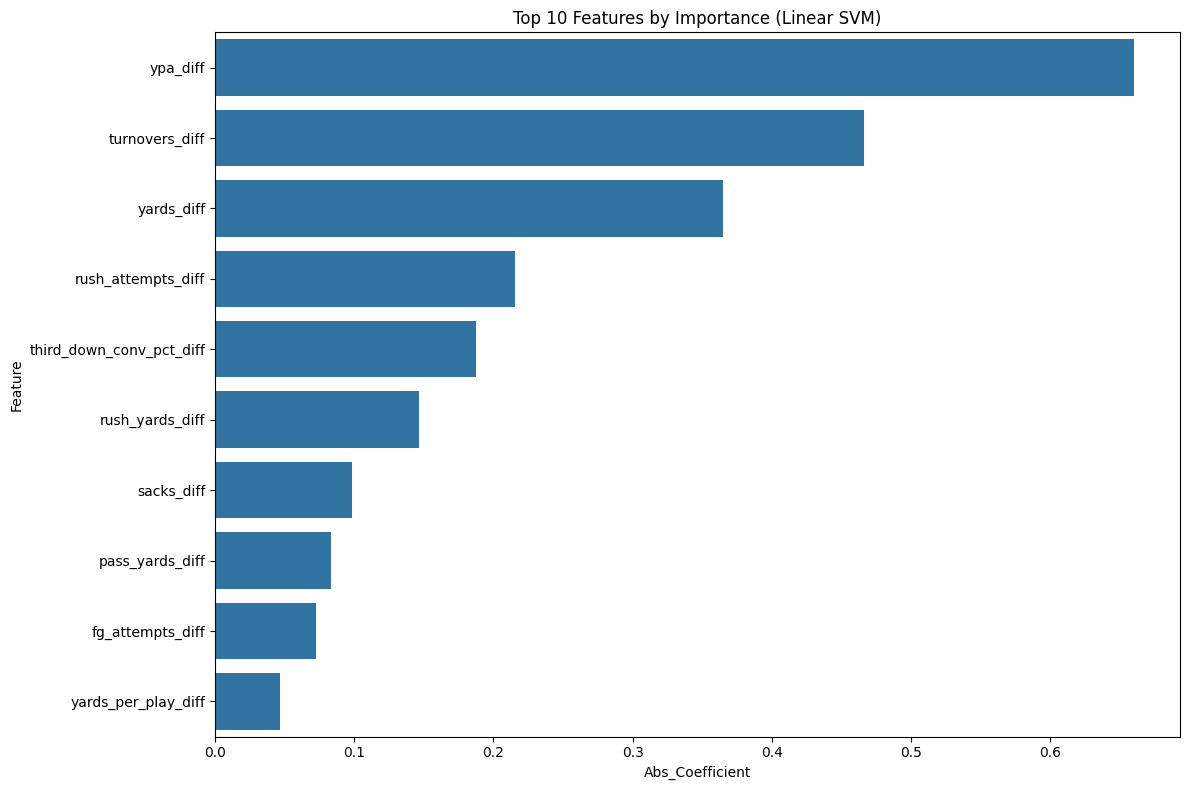

In [56]:
# Feature importance (for linear kernel only)
if best_svm.named_steps['svm'].kernel == 'linear':
    # Get the coefficients
    coefficients = best_svm.named_steps['svm'].coef_[0]
    
    # Create a DataFrame with features and their importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': coefficients
    })
    feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
    
    # Sort by absolute importance
    feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)
    
    print("\nFeature Importance (Top 10):")
    print(feature_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importance.head(10))
    plt.title('Top 10 Features by Importance (Linear SVM)')
    plt.tight_layout()
    plt.savefig('svm_feature_importance.png')
    print("Feature importance plot saved as 'svm_feature_importance.png'")


ROC curve plot saved as 'svm_roc_curve.png'


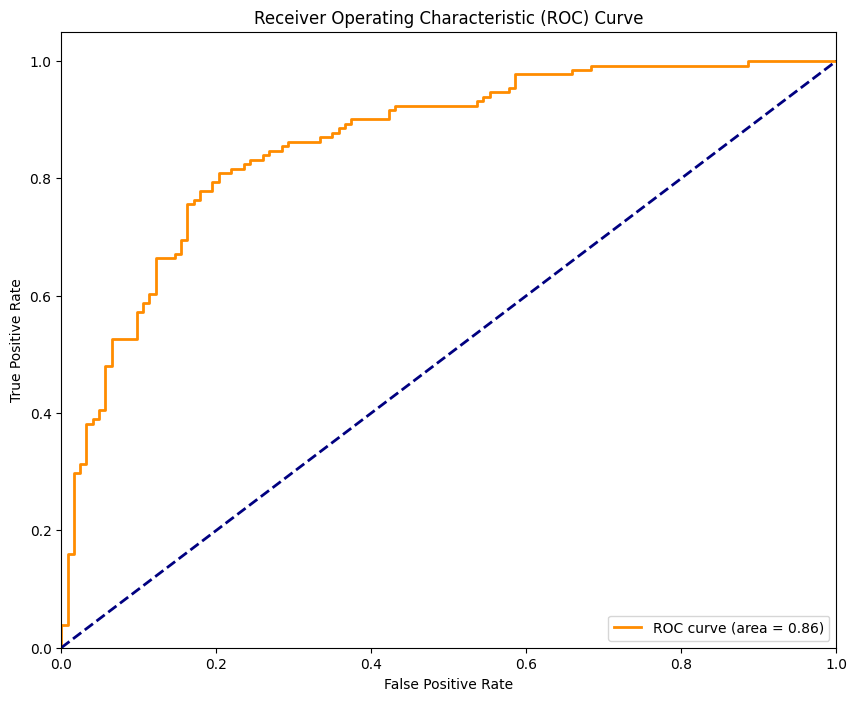

In [57]:
# Calculate ROC curve and plot
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('svm_roc_curve.png')
print("ROC curve plot saved as 'svm_roc_curve.png'")


In [58]:
# Implement cross-validation for reliability estimation
print("\nPerforming cross-validation...")
cv_scores = cross_val_score(best_svm, X, y, cv=cv, scoring='f1')
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1 score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



Performing cross-validation...
Cross-validation F1 scores: [0.743083   0.7810219  0.77692308 0.76494024 0.796875  ]
Mean CV F1 score: 0.7726 ± 0.0179



Comparing with baseline models...
Training Baseline Linear SVM...
Training Baseline RBF SVM...

Model Comparison:
                     Accuracy  F1 Score  Precision    Recall  \
Baseline Linear SVM  0.799213  0.799110   0.799230  0.799213   
Baseline RBF SVM     0.783465  0.783515   0.783784  0.783465   
Optimized SVM        0.799213  0.799110   0.799230  0.799213   

                     Training Time (s)  
Baseline Linear SVM           0.208839  
Baseline RBF SVM              0.177614  
Optimized SVM                 3.472796  
Model comparison plot saved as 'svm_model_comparison.png'


<Figure size 1200x800 with 0 Axes>

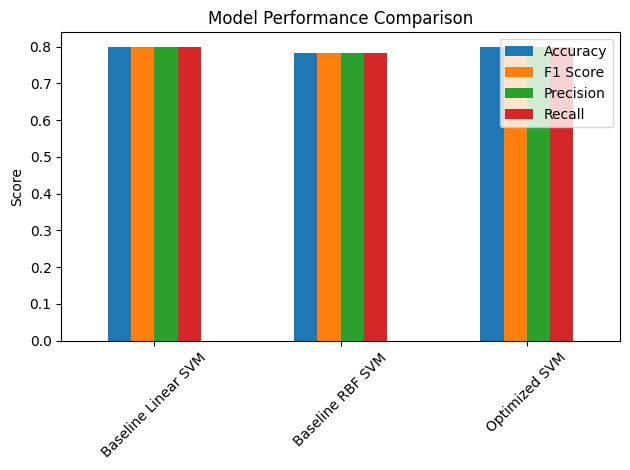

In [59]:
# Compare with baseline models (non-optimized)
print("\nComparing with baseline models...")

# Linear kernel baseline
baseline_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', probability=True, random_state=42))
])

# RBF kernel baseline
baseline_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
])

# Evaluate baseline models
models = {
    'Baseline Linear SVM': baseline_linear,
    'Baseline RBF SVM': baseline_rbf,
    'Optimized SVM': best_svm
}

results = {}

for name, model in models.items():
    if name != 'Optimized SVM':  # Skip the one we already trained
        print(f"Training {name}...")
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
    else:
        train_time = grid_search_time
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'F1 Score': report['weighted avg']['f1-score'],
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'Training Time (s)': train_time
    }

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# Create comparison bar chart
plt.figure(figsize=(12, 8))
results_df[['Accuracy', 'F1 Score', 'Precision', 'Recall']].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('svm_model_comparison.png')
print("Model comparison plot saved as 'svm_model_comparison.png'")



Generating learning curves...
Learning curve plot saved as 'svm_learning_curve.png'

SVM analysis complete!


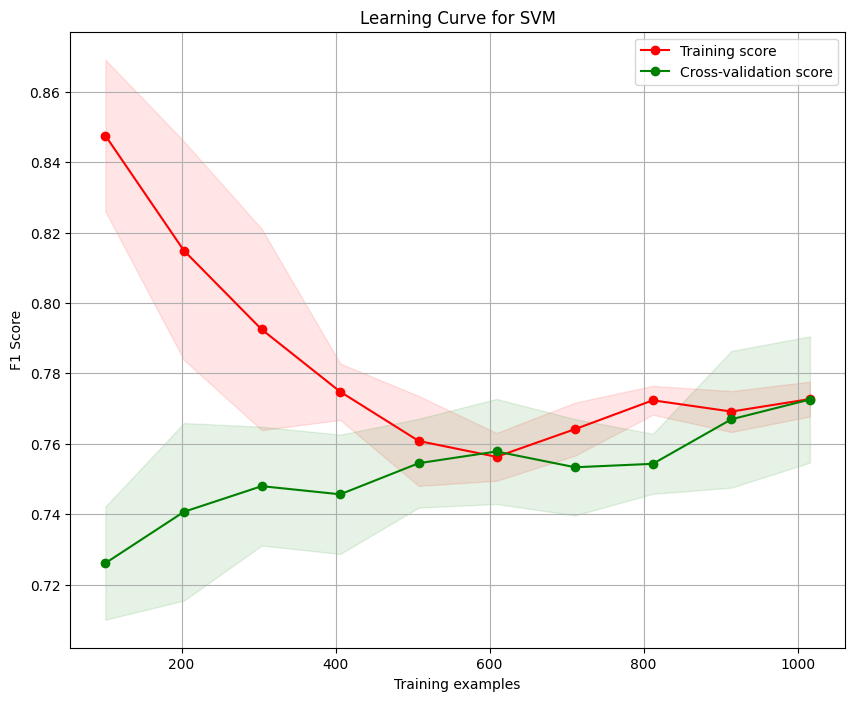

In [60]:
from sklearn.model_selection import learning_curve

print("\nGenerating learning curves...")
train_sizes, train_scores, test_scores = learning_curve(
    best_svm,
    X,
    y,
    cv=cv,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='f1'
)

# Calculate mean and std for train/test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 8))
plt.grid()
plt.fill_between(train_sizes, train_mean - train_std, 
                 train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("F1 Score")
plt.title("Learning Curve for SVM")
plt.legend(loc="best")
plt.savefig('svm_learning_curve.png')
print("Learning curve plot saved as 'svm_learning_curve.png'")

print("\nSVM analysis complete!")
